<a href="https://colab.research.google.com/github/josesg998/redesn_2024/blob/main/Clase%205/Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import keras
print(keras.__version__)  # Necesitamos tener la versión 3 de keras

3.3.3


In [4]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten, Layer
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import keras.backend as K
import tensorflow as tf
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

In [5]:
# Funciones útiles

def load_data():
  (x_train, _), (x_test, _) = mnist.load_data()
  input_dim = 28*28
  x_train = np.reshape(x_train, [-1, input_dim])/255.0
  x_test = np.reshape(x_test,   [-1, input_dim])/255.0

  return x_train,x_test,input_dim

def show_as_single_image(imgs,image_shape=None):
  if image_shape is None:
    n,h,w,c=imgs.shape
  else:
    h,w=image_shape
    n,c=imgs.shape
  imgs = imgs.reshape((n, h,w))
  imgs = imgs.swapaxes(1,2).reshape((n*w, h)).swapaxes(0,1)
  imgs = (imgs * 255).astype(np.uint8)

  plt.figure(figsize=(1*8,n*8),dpi=100)
  plt.axis('off')
  plt.imshow(imgs, interpolation='none', cmap='gray')
  plt.tight_layout()

def resize_images(x,size):
  n=x.shape[0]
  h,w=size
  new_x=np.zeros((n,h,w,1))
  for i in range(n):
    new_x[i,:,:,0]=resize(x[i,:,:],size).astype(np.float32)
  return new_x

def load_data_conv():
  size=32,32
  (x_train, _), (x_test, _) = mnist.load_data()
  print(f"Resizing training images to {size}...")
  x_train=resize_images(x_train,size)
  print(f"Resizing test images to {size}...")
  x_test=resize_images(x_test,size)
  input_shape = x_train.shape[1:]
  return x_train,x_test,input_shape

def show_images_conv(x,columns):
  if x.shape[3]==1:
    x = x.reshape(*x.shape[:3])
  n = x.shape[0]
  rows = n //  columns
  if (n % columns) > 0:
    rows+=1
  rows = max(rows,1)
  f, axes = plt.subplots(rows,columns,figsize=(columns,rows),dpi=100,squeeze=False)
  for i in range(rows):
    for j in range(columns):
      index = i*columns+j
      if index<n:
          axes[i,j].imshow(x[index,:],cmap="gray")
      axes[i,j].set_axis_off()

# Autoencoder basado en capas Dense

In [6]:
# Carga de datos

x_train,x_test,input_dim = load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Cantidad de features del espacio latente

latent_dim = 16

In [8]:
def DenseAutoencoder(input_dim,latent_dim):
  def generate_encoder():
    encoder_input = Input(shape=(input_dim,), name='encoder_input')
    code = Dense(latent_dim, name='latent_vector')(encoder_input)
    encoder = Model(encoder_input, code, name='encoder')
    return encoder,encoder_input

  def generate_decoder():
    latent_input = Input(shape=(latent_dim,), name='decoder_input')
    decoded_image = Dense(input_dim,activation="sigmoid",name='decoder_output')(latent_input)
    decoder = Model(latent_input, decoded_image, name='decoder')
    return decoder

  encoder,encoder_input = generate_encoder()
  decoder = generate_decoder()
  autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
  return autoencoder,encoder,decoder

autoencoder,encoder,decoder=DenseAutoencoder(input_dim,latent_dim)

autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 784)                 │          13,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,888 (101.12 KB)

 Trainable params: 25,888 (101.12 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 16)                  │          12,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,560 (49.06 KB)

 Trainable params: 12,560 (49.06 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 784)                 │          13,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,328 (52.06 KB)

 Trainable params: 13,328 (52.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Realizar el entrenamiento

epochs = 3
batch_size = 32
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=epochs, batch_size=batch_size)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1405 - val_loss: 0.1319
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1319 - val_loss: 0.1287
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1298 - val_loss: 0.1278


In [13]:
# Realizar la predicción

x_decoded = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Originales
Restauradas


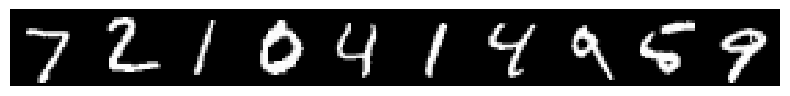

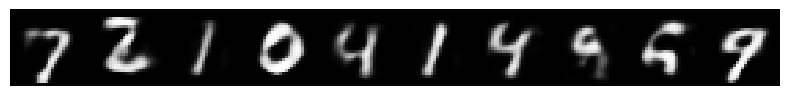

In [14]:
# Visualización de las imágenes originales y sus respectivas reconstrucciones

num=10 # cantidad de imágenes a visualizar
print("Originales")
show_as_single_image(x_test[:num],(28,28))
print("Restauradas")
show_as_single_image(x_decoded[:num],(28,28))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Imágenes generadas aleatoriamente


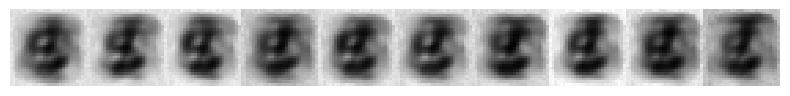

In [19]:
# Generar nuevas muestras completamente aleatorias desde el espacio latente

num_images=10 # Número de imágenes a generar

random_latent_code = np.random.random_sample([num_images,latent_dim])

random_images = decoder.predict(random_latent_code)

print("Imágenes generadas aleatoriamente")
show_as_single_image(random_images,(28,28))

# Autoencoder basado en capas Convolucionales

In [20]:
# Carga de datos

x_train,x_test,input_shape = load_data_conv()

Resizing training images to (32, 32)...
Resizing test images to (32, 32)...


In [21]:
# Cantidad de features del espacio latente

latent_dim = 16

In [22]:
def ConvolutionalAutoencoder(input_shape,latent_dim):
  filters = 32

  def generate_encoder():
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input
    x = Conv2D(filters*4, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters*2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded_shape = ops.shape(x)[1:]
    x = Flatten()(x)
    x = Dense(latent_dim)(x)

    encoder = Model(encoder_input, x, name='encoder')
    return encoder,encoder_input,encoded_shape

  def generate_decoder(encoded_shape):
    latent_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(np.prod(encoded_shape))(latent_input)
    x = Reshape(encoded_shape)(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_input, x, name='decoder')
    return decoder,latent_input

  encoder,encoder_input,encoded_shape = generate_encoder()
  decoder,latent_input = generate_decoder(encoded_shape)
  autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
  return autoencoder,encoder,decoder,encoded_shape

autoencoder,encoder,decoder,encoded_shape=ConvolutionalAutoencoder(input_shape,latent_dim=latent_dim)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │         104,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 32, 32, 1)           │         114,177 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,025 (855.57 KB)

 Trainable params: 219,025 (855.57 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,848 (409.56 KB)

 Trainable params: 104,848 (409.56 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,177 (446.00 KB)

 Trainable params: 114,177 (446.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Realizar el entrenamiento

epochs = 1
batch_size = 32
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs = epochs, batch_size=batch_size)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 770s 407ms/step - loss: 0.1896 - val_loss: 0.1254


In [24]:
# Realizar la predicción

x_decoded = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step


Original
Decoded


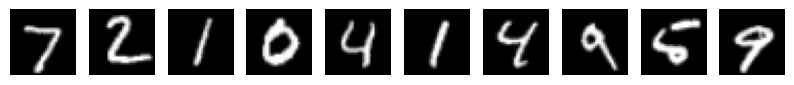

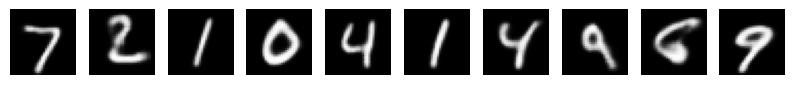

In [25]:
# Visualización de las imágenes originales y sus respectivas reconstrucciones

num=10 # cantidad de imágenes a visualizar
print("Original")
show_images_conv(x_test[:num],columns=num)
print("Decoded")
show_images_conv(x_decoded[:num],columns=num)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


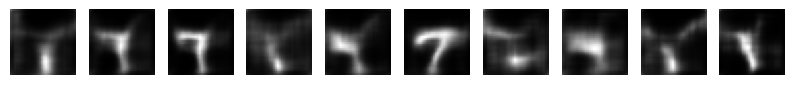

In [26]:
# Generar nuevas muestras completamente aleatorias desde el espacio latente

num_images=10 # Número de imágenes a generar

random_latent_code = np.random.random_sample([num_images,latent_dim])

random_images = decoder.predict(random_latent_code)

show_images_conv(random_images,columns=num_images)

#Autoencoder variacional

In [27]:
# Carga de datos

x_train,x_test,input_shape = load_data_conv()

Resizing training images to (32, 32)...
Resizing test images to (32, 32)...


In [28]:
# Cantidad de features del espacio latente

latent_dim = 8

In [29]:
# Construimos una capa que haga el sampleo

class Sampling(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [30]:
class VariationalAutoencoder(Model):
  def generate_encoder(this):
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(this.filters*4, (3, 3), activation='relu', strides=2, padding='same')(encoder_input)
    x = Conv2D(this.filters*8, (3, 3), activation='relu', strides=2, padding='same')(x)
    encoded_shape = ops.shape(x)[1:]
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    return encoder,encoded_shape

  def generate_decoder(this):
    latent_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(np.prod(this.encoded_shape), activation="relu")(latent_input)            #x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = Reshape(this.encoded_shape)(x)                                                 #x = layers.Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(this.filters*8, 3, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(this.filters*4, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_input, decoder_outputs, name="decoder")
    return decoder

  def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.filters = 8
        self.encoder, self.encoded_shape = self.generate_encoder()
        self.decoder = self.generate_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

  def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

autoencoder = VariationalAutoencoder()
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
autoencoder.summary()

Model: "variational_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ?                           │          84,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ ?                           │          92,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,185 (692.13 KB)

 Trainable params: 177,185 (692.13 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Realizar el entrenamiento

epochs = 1
batch_size = 32
history = autoencoder.fit(x_train, epochs = epochs, batch_size=batch_size)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 128s 67ms/step - kl_loss: 0.0059 - loss: 301.7333 - reconstruction_loss: 301.7298


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


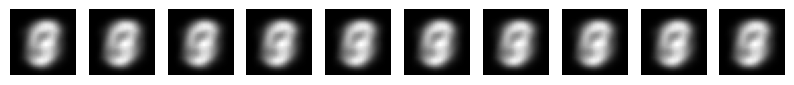

In [32]:
# Generar nuevas muestras completamente aleatorias desde el espacio latente

num_images=10 # Número de imágenes a generar

random_latent_code = np.random.random_sample([num_images,latent_dim])

random_images = autoencoder.decoder.predict(random_latent_code)

show_images_conv(random_images,columns=num_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


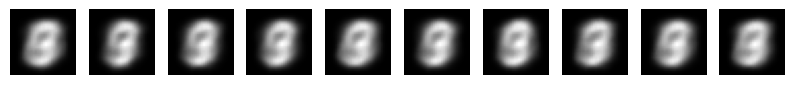

In [33]:
# Generar nuevas muestras completamente aleatorias desde el espacio latente (pero muestreando con las distribuciones conseguidas)

num_images=10 # Número de imágenes a generar

randoms = keras.random.normal(shape=(num_images, latent_dim))
z_mean, z_log_var, z = autoencoder.encoder(x_train[0:1,::])
random_latent_code = z_mean + ops.exp(0.5 * z_log_var) * randoms

random_images = autoencoder.decoder.predict(random_latent_code)

show_images_conv(random_images,columns=num_images)